### Линейная Регрессия
Будем оценивать влияние внешней привлекательности на уровень заработной платы при помощи линейной регрессии и разберем полезные практические трюки

In [114]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

from statsmodels.graphics.regressionplots import plot_leverage_resid2

warnings.filterwarnings('ignore')

sns.set_theme(style="ticks")

### Данные
Имеем 1260 наблюдений со следующими признаками:
- Заработная плата за час работы (доллары)
- Опыт работы (лет)
- Образование (лет)
- Внешняя привлекательность в баллах (1-5)
- Бинарные признаки: пол, семейное положение, состояние здоровья (хорошее/плохое), членство в профсоюзе, цвет кожи, занятость в сфере обслуживания (да/нет)

Требуется определить влияние внешней привлекательности на уровень заработка с учетом всех остальных факторов

In [115]:
cd C:\Users\vlad\1. Machine Learning\Yandex Specialization\4. Statistics for Data Analysis\week 3\data

C:\Users\vlad\1. Machine Learning\Yandex Specialization\4. Statistics for Data Analysis\week 3\data


In [116]:
data = pd.read_csv('beauty.csv', sep=';')
data.head()

,wage,exper,union,goodhlth,black,female,married,service,educ,looks
0,5.73,30,0,1,0,1,1,1,14,4
1,4.28,28,0,1,0,1,1,0,12,3
2,7.96,35,0,1,0,1,0,0,10,4
3,11.57,38,0,1,0,0,1,1,16,3
4,11.42,27,0,1,0,0,1,0,16,3


Взглянем на диаграммы рассеяния для количественных признаков

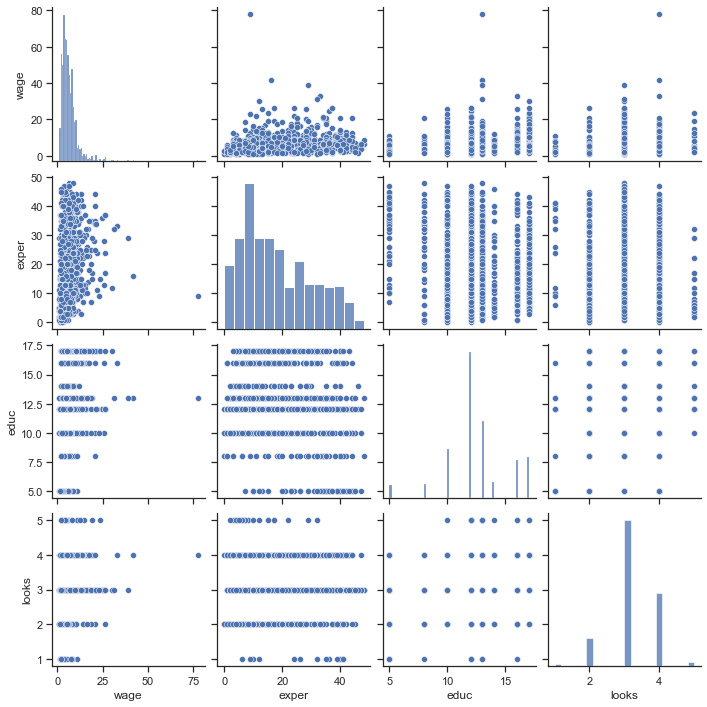

In [117]:
quant_features = ['wage', 'exper','educ', 'looks']

sns.pairplot(data[quant_features]);

Видно, что распределение уровян ЗП сильно скошено, скорее всего с этим нужно будет что-то сделать. Касаемо уровня привлекательности мы видим, что много испытуемых со средним уровнем привлекательности, очень привлекательных и совсем непривлекательных людей мало.

Для категориальных (бинарных) признаков оценим сбалансированность выборки

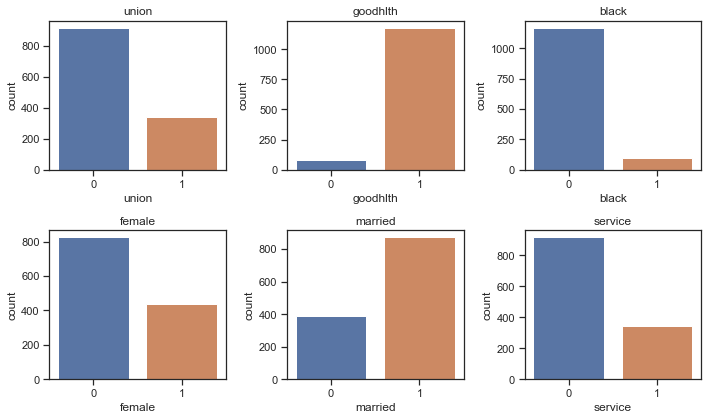

In [118]:
cat_features = ['union', 'goodhlth', 'black', 'female', 'married', 'service']

fig, axes = plt.subplots(2,3, figsize=(10, 6))
for indx, feat in enumerate(cat_features):
    sns.countplot(data[feat], ax=axes[ indx // 3, indx % 3])
    axes[ indx // 3, indx % 3].set_title(feat)
    plt.tight_layout()

Балансировка классов делается с той целью, чтобы определить есть ли значения бинарного/категориального признака которых очень мало. Если есть, то такие значения признака лучше удалить, т.к. это будет только мешать модели и вряд ли она сможет на данный признак хорошо настроиться.

В нашем случае дисбаланс наблюдается, однако он не слишком существенный. Каждого класса представлено достаточно. Нет признаков  для которых мы бы имели 3 или 2 объекта.

Посмотрим на распределение целевого признака (уровень ЗП в час)

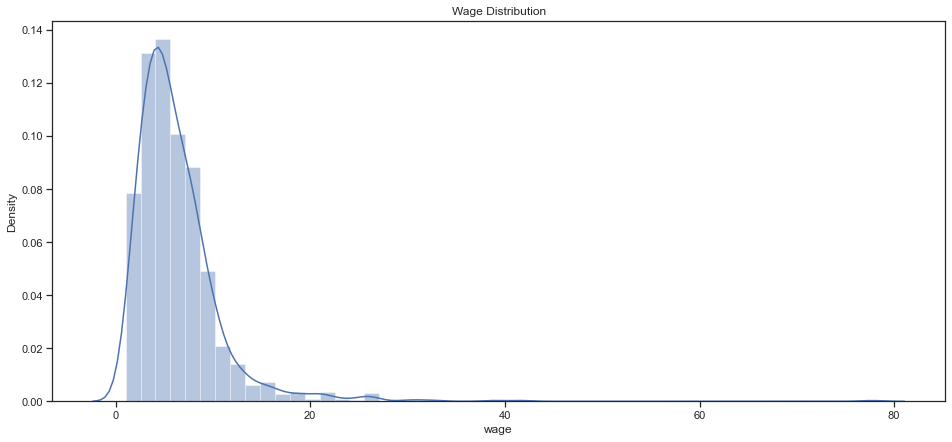

In [119]:
plt.figure(figsize=(16,7))
sns.distplot(data['wage'])
plt.title('Wage Distribution');

Видно что распределение сильно скошено и имеет тяжелый правый хвост. Это обуславливается тем, что людей с большой ЗП немного, и на нашей диаграмме явно имеются выбросы. Взгляем еще на boxplot

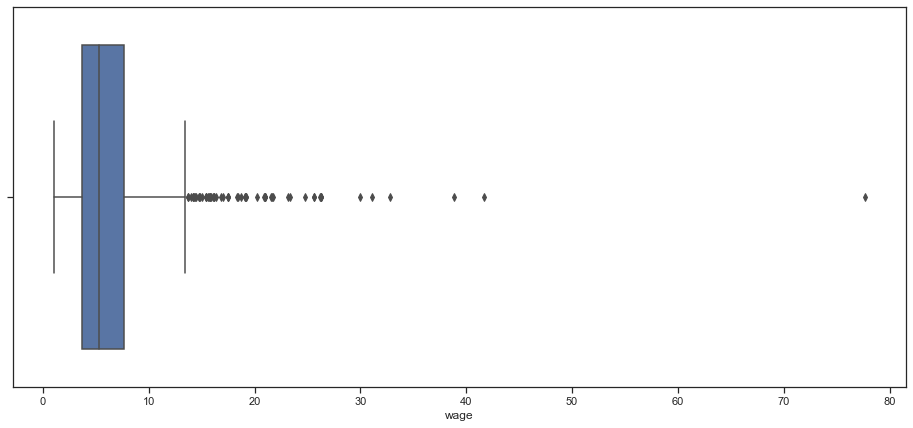

In [120]:
plt.figure(figsize=(16,7))
sns.boxplot(data['wage']);

Действительно, явно имеются выбросы. Видим наш единственный аномально большой выброс. Его средняя ЗП около 78$ в час, у основной массы меньше 40. Удалим данное наблюдение, чтобы регрессия так сказать не отвлекалась лишний раз на эту аномалию и не перенастраивалась, ведь это не имеет никакого смысла. Boxplot также показывает что имеются и другие выбросы

In [121]:
# Удаляем аномалию
data = data[data['wage'] < 70]

Для стабилизации распределения, прологарифмируем его

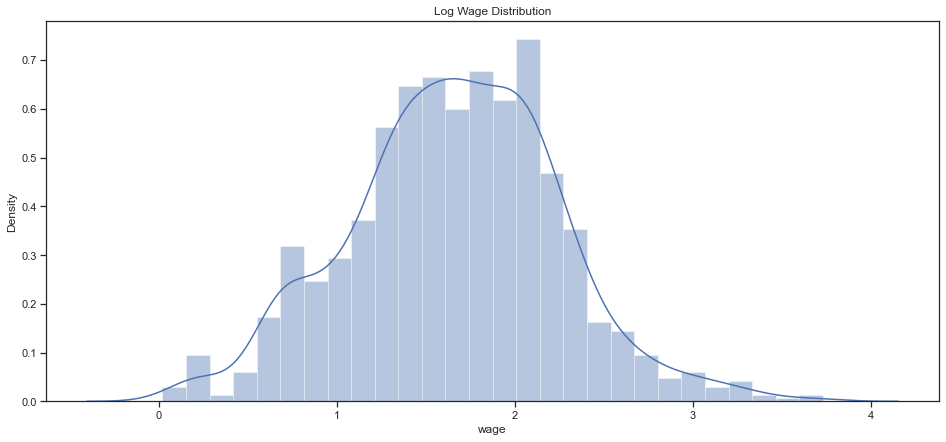

In [122]:
plt.figure(figsize=(16,7))
sns.distplot(np.log(data['wage']))
plt.title('Log Wage Distribution');

Также взглянем на распределение привлекательности

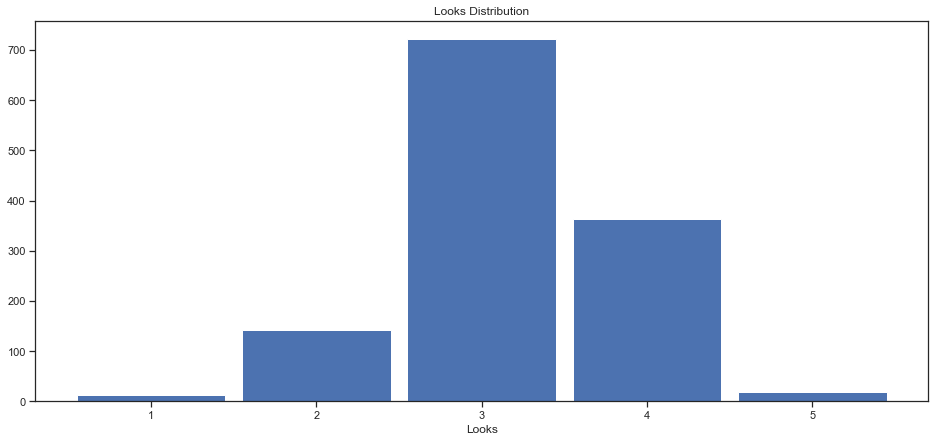

In [123]:
plt.figure(figsize=(16,7))
data.groupby(by='looks')['looks'].agg(lambda x: len(x)).plot(kind='bar', width=0.9)
plt.title('Looks Distribution')
plt.xlabel('Looks')
plt.xticks(rotation=0);

Как и прежде, очень мало наблюдений для некрасивых и очень красивых людей это категории 1 и 5. При этом средняя привлекательность 3. Создадим на основе данного распределения 2 новых бинарных признака:
- ```lk_below_avg``` привлекательность ниже среднего (<3)
- ```lk_above_avg``` привлекательность выше среднего (>3)

Старый признак при этом больше нам не нужен

In [124]:
# Создаем новые признаки и удаляем старый
data['lk_below_avg'] = data['looks'].apply(lambda x: 1 if x < 3 else 0)
data['lk_above_avg'] = data['looks'].apply(lambda x: 1 if x > 3 else 0)

data.drop('looks', axis=1, inplace=True)

### Построение модели 
Начнем с простейшей модели со всеми признаками. При этом мы будем пользоваться моделью ЛР из пакета statsmodels, т.к. именно модель из данного пакета позволяет автоматически рассчитывать большое количество различных статистических метрик.

In [125]:
# Запись немного необычная, вроде как на языке R
reg_model_1 = smf.ols('wage ~ exper + union + goodhlth + black + female + married +' \
                         'service + educ + lk_below_avg + lk_above_avg', data=data)

reg_model_1_fitted = reg_model_1.fit()
print(reg_model_1_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     44.31
Date:                Wed, 24 Feb 2021   Prob (F-statistic):           1.42e-75
Time:                        23:42:10   Log-Likelihood:                -3402.9
No. Observations:                1259   AIC:                             6828.
Df Residuals:                    1248   BIC:                             6884.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.5898      0.743     -0.793   

Что полезного мы здесь можем найти:
- ```R2``` - коэффициент детерменации
- ```Prob (F-statistic)``` - описывает значимость модели по критерию Фишера (значимость всех коэффициентов в совокупности)
- ```coef``` - значения коэффициентов модели
- ```std err``` - стандартное отклонение коэффициентов
- ```t``` - значение статистики Т - критерия Стьюдента
- ```P>|t|``` - достигаемый уровень значимости
- ```[0.025 0.975]``` - доверительный интервал для коэффициентов

Чтоюы понять насколько модель хороша, взглянем на **распределение её остатков**

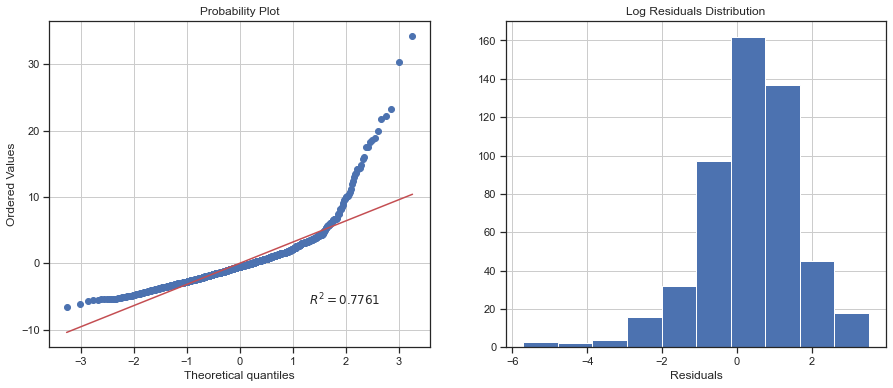

In [126]:
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.grid()
sc.stats.probplot(reg_model_1_fitted.resid, dist='norm', plot=plt, rvalue=True)

plt.subplot(122)
plt.title('Log Residuals Distribution')
np.log(reg_model_1_fitted.resid).hist()
plt.xlabel('Residuals');

На Q-Q-Plot точки лежат в основном не на прямой. Распределения остатков явно **не является нормальным.** Это плохо так-как мы хотим пользоваться критериями Стьюдента и Фишера для оценки значимости коэффициентов и построения доверительных интервалов, а в случае ненормальности остатков, данные критерии перестают работать.

В таких случаях помогает **логарифмирование**, т.е. мы переходим от регрессии исходного признака к регрессии его логарфима

### Регрессия логарифма отклика

In [127]:
reg_model_2 = smf.ols('np.log(wage) ~ exper + union + goodhlth + black + female + married +' \
                         'service + educ + lk_below_avg + lk_above_avg', data=data)

reg_model_2_fitted = reg_model_2.fit()
print(reg_model_2_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     77.63
Date:                Wed, 24 Feb 2021   Prob (F-statistic):          1.18e-123
Time:                        23:42:10   Log-Likelihood:                -816.90
No. Observations:                1259   AIC:                             1656.
Df Residuals:                    1248   BIC:                             1712.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.4515      0.095      4.737   

Взглянем на распределение остатков снова

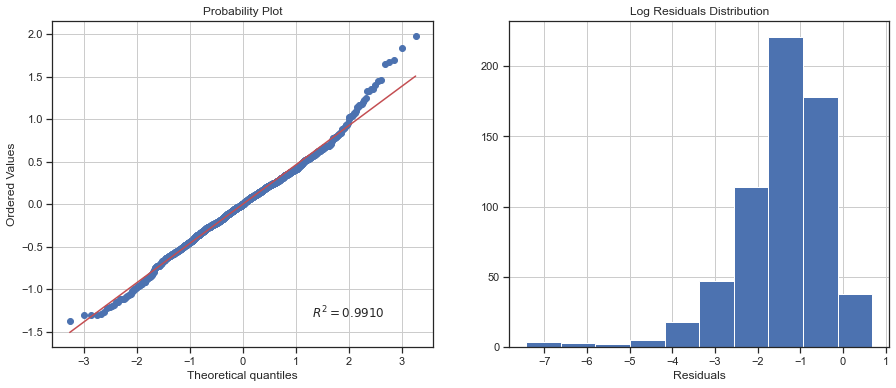

In [128]:
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.grid()
sc.stats.probplot(reg_model_2_fitted.resid, dist='norm', plot=plt, rvalue=True)

plt.subplot(122)
plt.title('Log Residuals Distribution')
np.log(reg_model_2_fitted.resid).hist()
plt.xlabel('Residuals');

Логарифмирование помагло, мы видим явное улучшение на Q-Q-Plot, однако левый правый хвост все еще сохраняется, но уже не такой большой как прежде.

Теперь взглянем как остатки меняются в зависимости от разных значений непрерывных признаков: ```exper``` и ```educ```

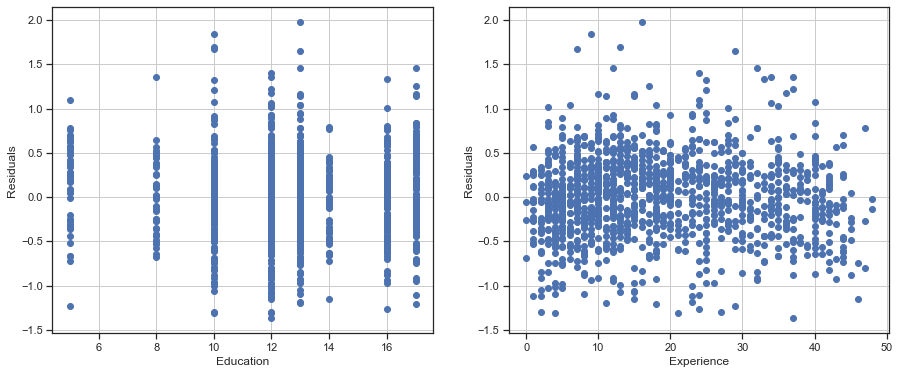

In [129]:
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.grid(True)
plt.scatter(data['educ'], reg_model_2_fitted.resid)
plt.xlabel('Education')
plt.ylabel('Residuals')

plt.subplot(122)
plt.grid(True)
plt.scatter(data['exper'], reg_model_2_fitted.resid)
plt.xlabel('Experience')
plt.ylabel('Residuals')
plt.show()

Если присмотреться, то кажется, что точки для ```Experience``` диаграммы рассеяния описывают некую дугу. Это сигнал к тому, что в остатках есть некая квадратичная зависимость от признака ```Experience```. В таком случае, подставим в модель квадрат опыта работы.

In [130]:
reg_model_3 = smf.ols('np.log(wage) ~ exper + np.power(exper, 2) + union + goodhlth + black + female + married +' \
                         'service + educ + lk_below_avg + lk_above_avg', data=data)

reg_model_3_fitted = reg_model_3.fit()
print(reg_model_3_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     76.46
Date:                Wed, 24 Feb 2021   Prob (F-statistic):          3.19e-131
Time:                        23:42:11   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3424      0

R2 стал еще больше, теперь мы объясняем 40 % изменчивости целевого признака

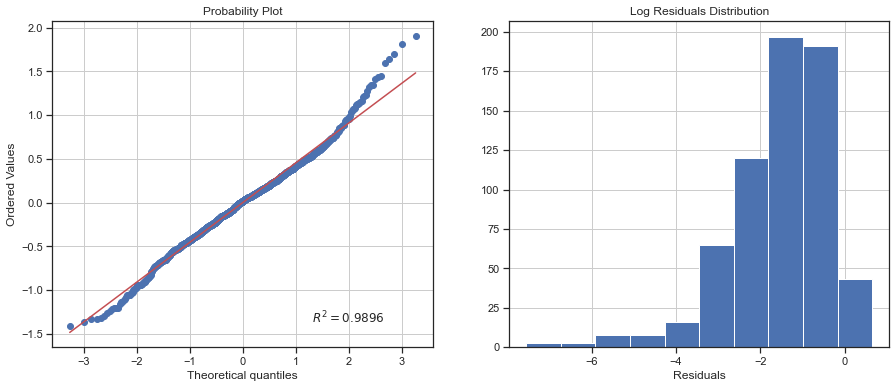

In [131]:
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.grid()
sc.stats.probplot(reg_model_3_fitted.resid, dist='norm', plot=plt, rvalue=True)

plt.subplot(122)
plt.title('Log Residuals Distribution')
np.log(reg_model_3_fitted.resid).hist()
plt.xlabel('Residuals');

Распределение самих остатков особо не изменилось

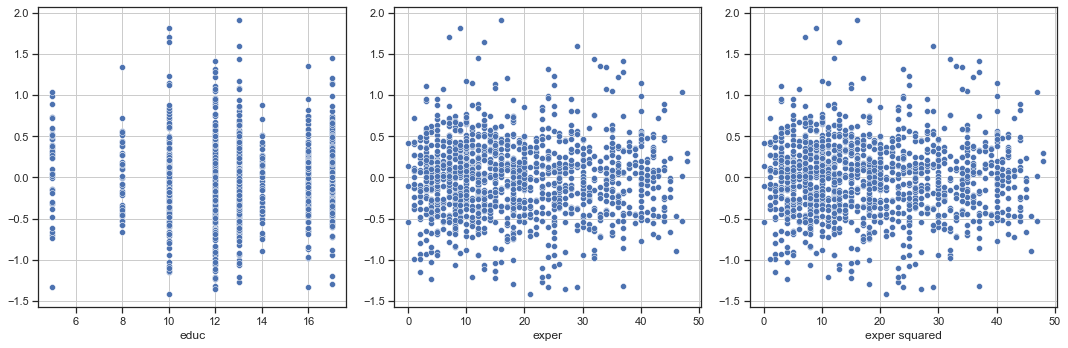

In [132]:
features = ['educ', 'exper', 'exper']

fig, axes = plt.subplots(1,3, figsize=(15, 5))
for indx, feat in enumerate(features):
    sns.scatterplot(data[feat], reg_model_3_fitted.resid, ax=axes[indx])
    axes[indx].grid()

axes[2].set_xlabel('exper squared')
plt.tight_layout()

Однако теперь мы учитываем закономерности признака ```Experience```, можем заметить, что распределение похоже на равномерное без каких либо закономерностей и структур.

Прежде чем переходить к интерпертации достигаемых уровней значимости и критерию Стьюдента для всех признаков, и затем сделать их отбор, проверим гомоскедастичность ошибок (если ошибки негомоскедастичны, то критерий Стьюдента будет работать плохо)

Для проверки гомоскедастичности ошибок используем функцию Бройша-Пагана

H_0: остатки гомоскедастичны

In [133]:
print('Breusch-Pagan Criterion p-value: ', sms.het_breuschpagan(reg_model_3_fitted.resid, reg_model_3_fitted.model.exog)[1])

Breusch-Pagan Criterion p-value:  4.192584368288051e-06


Критерий Бройша-Пагана отвергает нулевую гипотезу, **остатки гетероскедастичны.** Значит значимость признаков может определяться неверно. В такой ситуации можно сделать **поправку Уайта** (пересчитывает значение дисперсии коэффициентов регрессии с учетом присутствия гетероскедастичности в модели). Если гетероскедастичности нет, то данная поправка менее точна, поэтому перед использованием данной поправки надо всегда определять ее необходимость.

In [134]:
reg_model_4 = smf.ols('np.log(wage) ~ exper + np.power(exper, 2) + union + goodhlth + black + female + married +' \
                         'service + educ + lk_below_avg + lk_above_avg', data=data)

# Для использования поправки Уайта, используй параметр cov_type='HC1'
reg_model_4_fitted = reg_model_4.fit(cov_type='HC1')
print(reg_model_4_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     87.29
Date:                Wed, 24 Feb 2021   Prob (F-statistic):          4.23e-146
Time:                        23:42:12   Log-Likelihood:                -796.86
No. Observations:                1259   AIC:                             1618.
Df Residuals:                    1247   BIC:                             1679.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3424      0

Снова проверять гомоскедастичность остатков не нужно, они все равно будут гетероскедастичны, однако значения коэффициентов при ризнаках скорректировались с учетом гетероскедастичности (они изменились не слишком сильно, что свидетельствуте от незначительной гетероскедастичности в модели). Теперь можно приступить к отбору признаков.

Незначимые признаки:
- goodhlth 
- black
- married
- lk_above_avg

### Удаляем незначимые признаки
```lk_above_avg``` удалять не будем, так как по этому признаку нам нужно ответить на вопрос, а остальные удалим. 

In [135]:
reg_model_5 = smf.ols('np.log(wage) ~ exper + np.power(exper, 2) + union + female +' \
                         'service + educ + lk_below_avg + lk_above_avg', data=data)

# Для использования поправки Уайта, используй параметр cov_type='HC1'
reg_model_5_fitted = reg_model_5.fit(cov_type='HC1')
print(reg_model_5_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(wage)   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     121.1
Date:                Wed, 24 Feb 2021   Prob (F-statistic):          6.49e-150
Time:                        23:42:12   Log-Likelihood:                -799.30
No. Observations:                1259   AIC:                             1617.
Df Residuals:                    1250   BIC:                             1663.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3906      0

Даже бессмысленные признаки увеличивают ```R2```, поэтому если мы их удалим, то качество модели должно слегка ухудшиться. При этом все коэффициенты (кроме ```lk_above_avg``` значимы). Значит, они действительно помогают предсказывать целевую переменную.

Теперь необходимо убедиться при помощи критерия Фишера, что удаление сразу 3-х незначимых по критерию Стьюдента признаков не привело к значимому ухудшению модели.

H_0 качество модели не изменилосьв "худшую сторону"

In [136]:
# Необходим сперва указать модель большую (с большим числом признаков) затем меньшую (вложенную в большую)
print('F=%f, p-value:%f, k1=%f' %reg_model_4.fit().compare_f_test(reg_model_5.fit()))

F=1.611478, p-value:0.184911, k1=3.000000


Мы не можем отвергнуть гипотезу о том, что признаки которые мы выбросили были действительно не нужны.

Далее посчитаем влиятельность всех наблюдений выборки. Регрессия склонна перенастраиваться на нетипичные наблюдения, т.е. на наблюдения, находящиеся далеко от основного облака точек ("выбросы"). При минимизации квадратов отклонений, такие далеки точки дадут огромный вклад при минимизации среднеквадратичной ошибки, и прямая будет стремиться пройти как можно ближе к выбросам, в результате, для основной массы точке мы получим плохое качество. Нужно убедиться, что таких точек в выборке нет.

Один из способов построить график ```Leverage Residual Plot```

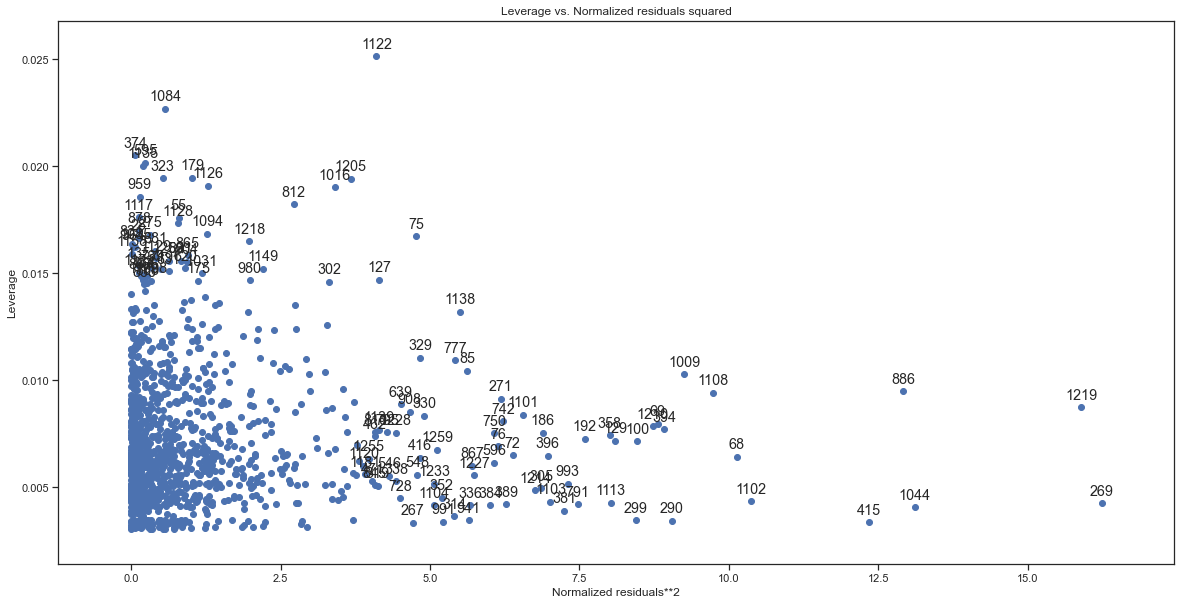

In [145]:
plt.rcParams['figure.figsize'] = (20,10)
plot_leverage_resid2(reg_model_5_fitted)
plt.show()

На данном на графике по оси X отложены квадраты остатков (квадрат ошибки предсказания для каждого объекта), а по оси Y влиятельность наблюдений (чем больше, тем сильнее наблюдение влияет на регрессионное руавнение). 

Степень влияние вычисляется следующим образом: Из исходной выборки по очереди удаляются по 1 наблюдению каждый раз, перестраивая уравнение регрессии (т.е. размер каждого сокращенного уравнения n-1). 

Затем сравниваются 2 уравнения: полное и сокращенное, определяется между нимим разница, эта разница и есть степень влияния объекта.

На нашем графике мы видим, что нет точке которые экстримально далеко лежат от основного облака точек по влиятельности.

- Самое влиятельное наблюдение: 1122
- Наблюдение на котором мы сильнее всего ошибаемся 269

Взглянем на данные наблюдения подробнее и выясним: действительно ли с нимим что-то не так?

In [148]:
data.loc[[1122]]

,wage,exper,union,goodhlth,black,female,married,service,educ,lk_below_avg,lk_above_avg
1122,6.25,47,0,0,1,1,1,0,5,0,1


Нужно рассуждать так: самое влиятельное наблюдение соответствует темнокожей замужней женщине с небольшим образованием, привлекательностью выше среднего и очень большим опытом работы. Скорее всего такая большая влиятельность обусловлена **большим опытом работы**

In [149]:
data.loc[[269]]

,wage,exper,union,goodhlth,black,female,married,service,educ,lk_below_avg,lk_above_avg
269,41.67,16,0,0,0,0,1,0,13,0,1


Точка на которой мы больше всего ошибаемся: женатый белый мужчина с хорошим образованием, привлекательностью выше среднего, не очень большим опытом работы и очень **большой ЗП**. Большая ошибка скорее всего обусловлена аномально большим уровнем ЗП, для такого наблюдения наша модель не допредсказывает уровень ЗП.

Тем не менее, особо аномальных точек на графике нет и можно остановиться.

### Выводы
Модель объясняет до 40 % логарифма изменчивости целевой переменной/отклика (wage)

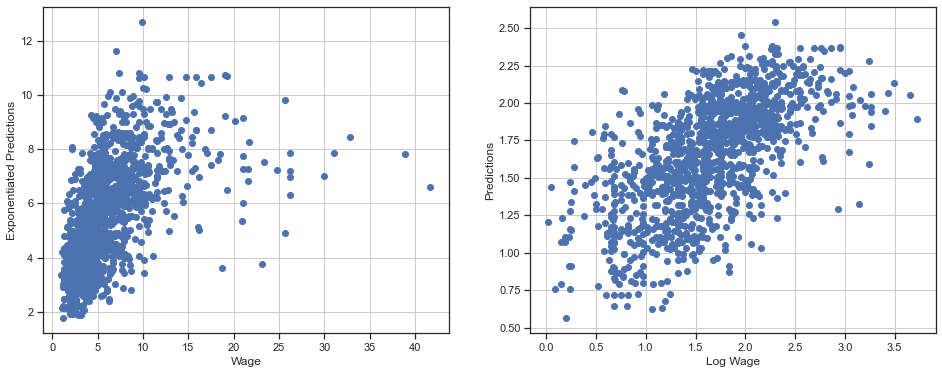

In [156]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.scatter(data['wage'], np.exp(reg_model_5_fitted.fittedvalues))
plt.xlabel('Wage')
plt.ylabel('Exponentiated Predictions')
plt.grid()

plt.subplot(122)
plt.scatter(np.log(data['wage']), reg_model_5_fitted.fittedvalues)
plt.xlabel('Log Wage')
plt.ylabel('Predictions')
plt.grid()

Видим, что облако не совсем диагональное, но и R2 всего лишь 40 %, т.е. задача сложная для ЛР, и предсказать уровень ЗП по нашим признакам сложно. Наша основная задача была оценить влияние привлекательности на целевую переменную.

- lk_below_avg: -0.1307
- lk_above_avg: -0.0010

Так как линейная регрессия обучалась на логарфим целевой переменной, то коэффициенты нужно интерпретировать как прирост в процентах. Интерпертация должа озвучиваться следующим образом: представители генеральной совокупности из которой взята наша выборка и с учетом рассмотренных нами признаков, получают в среднем (уровень ЗП):
- на 13% меньше если их привлекательность ниже среднего (p-value:0.001, 95% ДИ - [от 5 до 21]%)
- столько же, сколько и люди со средним уровнем привлекательности, если их привлекательность выше среднего (p-value:0.972, 95% ДИ - [от -6 до 6]%). Содержит 0, пизнак не является информативным.
